In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 26.5MB/s 
     |████████████████████████████████| 901kB 40.8MB/s 
     |████████████████████████████████| 3.3MB 37.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.8.1+cu101'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ner_dataset_crimes_modified - Copy.csv to ner_dataset_crimes_modified - Copy.csv


In [ ]:
data = pd.read_csv("ner_dataset_crimes_modified - Copy.csv", encoding="latin1").fillna(method="ffill")
data.tail(10) 

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,",",",",O
1048566,Sentence: 47958,Banjara,NNP,B-geo
1048567,Sentence: 47959,Hills,NNP,I-geo
1048568,Sentence: 47959,is,VBZ,O
1048569,Sentence: 47959,a,DT,O
1048570,Sentence: 47959,lorry,NN,O
1048571,Sentence: 47959,driver,NN,O
1048572,Sentence: 47959,by,IN,O
1048573,Sentence: 47959,profession,NN,O
1048574,Sentence: 47959,.,.,O


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [ ]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_values

['B-gpe',
 'I-art',
 'B-art',
 'I-geo',
 'B-org',
 'I-org',
 'I-nat',
 'I-eve',
 'B-geo',
 'I-per',
 'I-gpe',
 'B-per',
 'B-nat',
 'O',
 'I-tim',
 'B-eve',
 'B-tim',
 'PAD']

In [ ]:
tag2idx

{'B-art': 2,
 'B-eve': 15,
 'B-geo': 8,
 'B-gpe': 0,
 'B-nat': 12,
 'B-org': 4,
 'B-per': 11,
 'B-tim': 16,
 'I-art': 1,
 'I-eve': 7,
 'I-geo': 3,
 'I-gpe': 10,
 'I-nat': 6,
 'I-org': 5,
 'I-per': 9,
 'I-tim': 14,
 'O': 13,
 'PAD': 17}

In [ ]:
tag_values = tag_values

In [ ]:
tag2idx = tag2idx

In [ ]:
tag_values

['B-gpe',
 'I-art',
 'B-art',
 'I-geo',
 'B-org',
 'I-org',
 'I-nat',
 'I-eve',
 'B-geo',
 'I-per',
 'I-gpe',
 'B-per',
 'B-nat',
 'O',
 'I-tim',
 'B-eve',
 'B-tim',
 'PAD']

In [ ]:
tag2idx

{'B-art': 2,
 'B-eve': 15,
 'B-geo': 8,
 'B-gpe': 0,
 'B-nat': 12,
 'B-org': 4,
 'B-per': 11,
 'B-tim': 16,
 'I-art': 1,
 'I-eve': 7,
 'I-geo': 3,
 'I-gpe': 10,
 'I-nat': 6,
 'I-org': 5,
 'I-per': 9,
 'I-tim': 14,
 'O': 13,
 'PAD': 17}

In [ ]:
MAX_LEN = 128
bs = 32

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bert-base-cased-vocab.txt to bert-base-cased-vocab.txt


In [ ]:
vocabulary = "bert-base-cased-vocab.txt"

In [ ]:
tokenizer=BertTokenizer(vocab_file=vocabulary,do_lower_case=False)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.6.0'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.2010046940691477
Validation loss: 0.13980576331416766


Epoch:  25%|██▌       | 1/4 [14:28<43:24, 868.08s/it]

Validation Accuracy: 0.9565537311705277

Average train loss: 0.11289304103531422
Validation loss: 0.12751624565571545


Epoch:  50%|█████     | 2/4 [29:05<29:01, 870.96s/it]

Validation Accuracy: 0.9599434495758719

Average train loss: 0.08420619730673749
Validation loss: 0.13033060368150473


Epoch:  75%|███████▌  | 3/4 [43:45<14:33, 873.49s/it]

Validation Accuracy: 0.9614481538436099

Average train loss: 0.06425831487730108
Validation loss: 0.14025204602628946


Epoch: 100%|██████████| 4/4 [58:23<00:00, 875.87s/it]

Validation Accuracy: 0.9616589777932106



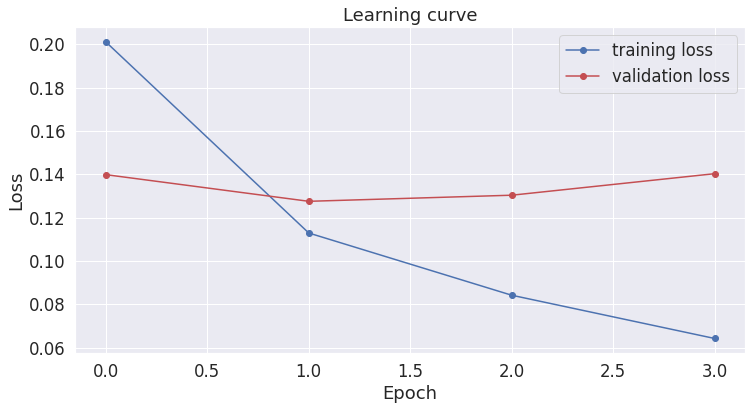

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentence = """
In a bid to keep human trafficking in check, Rachakonda police commissioner Mahesh M Bhagwat on Wednesday invoked the Public Disturbance (PD) Act against a trafficker, who was arrested earlier for organizing a prostitution ring under the Kushaiguda police limits.
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	In
O	a
O	bid
O	to
O	keep
B-eve	human
B-eve	trafficking
O	in
O	check
O	,
B-geo	Rachakonda
B-org	police
O	commissioner
B-per	Mahesh
I-org	M
I-per	Bhagwat
O	on
B-tim	Wednesday
O	invoked
O	the
O	Public
O	Disturbance
O	(
O	PD
O	)
O	Act
O	against
O	a
B-eve	trafficker
O	,
O	who
O	was
O	arrested
O	earlier
O	for
O	organizing
O	a
B-eve	prostitution
O	ring
O	under
O	the
B-geo	Kushaiguda
B-org	police
O	limits
O	.
O	[SEP]


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model

In [ ]:
output_model_file = "./drive/MyDrive/BERT4Model/pytorch_model.bin"
output_config_file = "./drive/MyDrive/BERT4Model/config.json"

In [ ]:
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary("./drive/MyDrive/BERT4Model")

('./drive/MyDrive/BERT4Model/vocab.txt',)

In [ ]:
MAX_LEN = 128
bs = 32

In [ ]:
tag2idx

{'B-art': 1,
 'B-eve': 0,
 'B-geo': 4,
 'B-gpe': 3,
 'B-nat': 16,
 'B-org': 2,
 'B-per': 10,
 'B-tim': 7,
 'I-art': 6,
 'I-eve': 12,
 'I-geo': 14,
 'I-gpe': 11,
 'I-nat': 5,
 'I-org': 8,
 'I-per': 15,
 'I-tim': 13,
 'O': 9,
 'PAD': 17}

In [ ]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

In [ ]:
output_dir = "./drive/MyDrive/pyModel"

In [ ]:
saved_model = BertForTokenClassification.from_pretrained(output_dir)
s_tokenizer = BertTokenizer.from_pretrained(output_dir)

In [ ]:
saved_model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
test = """
I live in London.
"""

In [ ]:
tokenized_sentence = s_tokenizer.encode(test)

In [ ]:
ip_ids = torch.tensor([tok_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = saved_model(ip_ids)
lab_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join bpe split tokens
token_s = s_tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
n_tokens, n_labels = [], []
for tk, lab_idx in zip(token_s, lab_indices[0]):
    if tk.startswith("##"):
        n_tokens[-1] = n_tokens[-1] + tk[2:]
    else:
        n_labels.append(tag_values[lab_idx])
        n_tokens.append(tk)

In [ ]:
for t, l in zip(n_tokens, n_labels):
    print("{}\t{}".format(l, t))

O	[CLS]
O	A
O	Special
O	Operations
B-geo	Team
O	belonging
O	to
O	Ra
